<a href="https://colab.research.google.com/github/vieduy/CheXpert/blob/main/CheXpert_HandleImbalance_DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download datasets on kaggle

In [ ]:
import os
FOLDER_PATH = 'train_aug'
ROOT_PATH = '/content/drive/MyDrive/CheXpert-v1.0'
print(len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH))))

7596


In [ ]:
!nvidia-smi

Mon Feb 21 15:01:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import library

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

In [ ]:
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision

from fastprogress import master_bar, progress_bar

from PIL import Image

In [ ]:
cd drive/MyDrive/CheXpert-v1.0

/content/drive/.shortcut-targets-by-id/1-RDgNs_TCBkE_HeXI4VdP0dIXvWo9nXH/CheXpert-v1.0


In [ ]:
ls

aug_train.csv       densenet.pth  train/      train_final.csv
Correlation.png     test/         train_aug/  train_meta.csv
DataDistribute.png  test.csv      train.csv   valid/


## Data Augmentation for Minority class 

#### Get instance of minority class

In [ ]:
def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

In [ ]:
# read train.csv

data = pd.read_csv("./train.csv")
data

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,000434271f63a053c4128a0ba6352c7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00053190460d56c53cc3e57321387478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20707,ffe6f9fe648a7ec29a50feb92d6c15a4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20708,ffea246f04196af602c7dc123e5e48fc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20709,ffeffc54594debf3716d6fcd2402a99f,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20710,fff0f82159f9083f3dd1f8967fc54f6a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X = data.iloc[:, 0]
Y = data.iloc[:, 1:]
Y

,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20707,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20709,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Get minority samples
X_sub, y_sub = get_minority_samples(X, Y)

In [ ]:
y_sub

,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3410,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
3411,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3412,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


#### Clone label for each instance in minority class. 3414 rows x 5 => 17070 rows


In [ ]:
newdf = pd.DataFrame(np.repeat(y_sub.values, 5, axis=0))
newdf.columns = y_sub.columns
newdf

,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17065,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
17066,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
17067,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
17068,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


#### Data augmentation for each images

In [ ]:
!pip install -U albumentations

In [ ]:
!pip install opencv-python-headless==4.1.2.30

In [ ]:
import albumentations as A
import cv2
from google.colab.patches import cv2_imshow

# Declare an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.augmentations.transforms.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1.0),
    A.augmentations.geometric.transforms.Affine (scale=None, translate_percent=None, translate_px=None, rotate=None, shear=None, interpolation=1, 
            mask_interpolation=0, cval=0, cval_mask=0, mode=0, fit_output=False, always_apply=False, p=0.8)
    
])

X_aug = []
# Read an image with OpenCV and convert it to the RGB colorspace
for path_image in X_sub.values:
  X_aug.append(path_image)
  image = cv2.imread('train/'+path_image+'.png')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Augment an image
  for i in range(4):
    transformed = transform(image=image)
    transformed_image = transform(image=image)['image']
    path_image_aug = 'train_aug/'+ path_image + '_'+ str(i) + '.png'
    cv2.imwrite(path_image_aug,transformed_image)
    X_aug.append(path_image+'_'+str(i))
    

#### Create dataframe after data augmentation

In [ ]:
df_image = pd.DataFrame(X_aug, columns = ['image_id'])
df_image

,image_id
0,0005e8e3701dfb1dd93d53e2ff537b6e
1,train_aug/0005e8e3701dfb1dd93d53e2ff537b6e_0.png
2,train_aug/0005e8e3701dfb1dd93d53e2ff537b6e_1.png
3,train_aug/0005e8e3701dfb1dd93d53e2ff537b6e_2.png
4,train_aug/0005e8e3701dfb1dd93d53e2ff537b6e_3.png
...,...
17065,ff924bcbd38f123aec723aa7040d7e43
17066,train_aug/ff924bcbd38f123aec723aa7040d7e43_0.png
17067,train_aug/ff924bcbd38f123aec723aa7040d7e43_1.png
17068,train_aug/ff924bcbd38f123aec723aa7040d7e43_2.png


In [ ]:
final_data = pd.concat([df_image, newdf.reindex(newdf.index)], axis=1)
final_data

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,train_aug/0005e8e3701dfb1dd93d53e2ff537b6e_0.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train_aug/0005e8e3701dfb1dd93d53e2ff537b6e_1.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train_aug/0005e8e3701dfb1dd93d53e2ff537b6e_2.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,train_aug/0005e8e3701dfb1dd93d53e2ff537b6e_3.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17065,ff924bcbd38f123aec723aa7040d7e43,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
17066,train_aug/ff924bcbd38f123aec723aa7040d7e43_0.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
17067,train_aug/ff924bcbd38f123aec723aa7040d7e43_1.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
17068,train_aug/ff924bcbd38f123aec723aa7040d7e43_2.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
final_data.to_csv('aug_train.csv', index=False)

In [ ]:
before_aug = pd.read_csv('train.csv')
before_aug

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,000434271f63a053c4128a0ba6352c7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00053190460d56c53cc3e57321387478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20707,ffe6f9fe648a7ec29a50feb92d6c15a4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20708,ffea246f04196af602c7dc123e5e48fc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20709,ffeffc54594debf3716d6fcd2402a99f,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20710,fff0f82159f9083f3dd1f8967fc54f6a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
final_dataset = pd.concat([before_aug, final_data], ignore_index=True)
final_dataset

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,000434271f63a053c4128a0ba6352c7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00053190460d56c53cc3e57321387478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37777,ff924bcbd38f123aec723aa7040d7e43,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
37778,train_aug/ff924bcbd38f123aec723aa7040d7e43_0.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
37779,train_aug/ff924bcbd38f123aec723aa7040d7e43_1.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
37780,train_aug/ff924bcbd38f123aec723aa7040d7e43_2.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
final_dataset.drop_duplicates(inplace=True, ignore_index=True)
final_dataset

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,000434271f63a053c4128a0ba6352c7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00053190460d56c53cc3e57321387478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34363,train_aug/ff924bcbd38f123aec723aa7040d7e43_3.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
34364,train_aug/ff924bcbd38f123aec723aa7040d7e43_0.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
34365,train_aug/ff924bcbd38f123aec723aa7040d7e43_1.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
34366,train_aug/ff924bcbd38f123aec723aa7040d7e43_2.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
final_dataset.to_csv('train_final.csv', index=False)

#### Visualize some examples

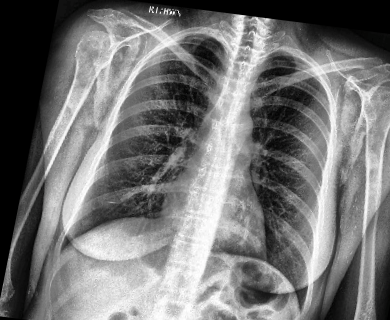

In [ ]:
cv2_imshow(transformed_image_1)

## Training model

In [ ]:
# read train.csv

data = pd.read_csv("./train.csv")
data

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,000434271f63a053c4128a0ba6352c7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00053190460d56c53cc3e57321387478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20707,ffe6f9fe648a7ec29a50feb92d6c15a4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20708,ffea246f04196af602c7dc123e5e48fc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20709,ffeffc54594debf3716d6fcd2402a99f,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20710,fff0f82159f9083f3dd1f8967fc54f6a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Get label names

LABELS = data.columns[1:]
LABELS

Index(['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
       'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass',
       'Other lesion', 'Pleural effusion', 'Pleural thickening',
       'Pneumothorax', 'Pulmonary fibrosis', 'No Finding'],
      dtype='object')

In [ ]:
# Split train-val

train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)

In [ ]:
val_data

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
19517,f0267345c2bb297314f8c9db2b33ffb2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19536,f0779544e2abbf51d3ac17e208ff29df,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18938,e925b5b0b88c9d5cfbced3b3552fa456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12315,986a142a1300b3401bdeda43822ceba6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6267,4e1c7c8139ca923967f318edb0fec0e6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18334,e1a4353d3e747a7150cb06cac73f4d6f,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,78ea1df200023de69c0cf9d0c8a28658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19112,eb6c714df22142229464c6b83e47d7d6,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7014,575c1973c2d617658508d18d94bc2ffa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
val_data.to_csv('val_df.csv')

In [ ]:
train_data.to_csv('train_df.csv')

In [ ]:
data_aug = pd.read_csv('aug_train.csv')
data_aug

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0005e8e3701dfb1dd93d53e2ff537b6e_0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0005e8e3701dfb1dd93d53e2ff537b6e_1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0005e8e3701dfb1dd93d53e2ff537b6e_2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0005e8e3701dfb1dd93d53e2ff537b6e_3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17065,ff924bcbd38f123aec723aa7040d7e43,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
17066,ff924bcbd38f123aec723aa7040d7e43_0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
17067,ff924bcbd38f123aec723aa7040d7e43_1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
17068,ff924bcbd38f123aec723aa7040d7e43_2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
final_trainset = pd.concat([train_data, data_aug], ignore_index=True)
final_trainset.drop_duplicates(inplace=True, ignore_index=True)
final_trainset

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No Finding
0,40db43057f32f22dacd78f2415b142c2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4da6d92e1eeeed4658aaa52ce11fe8f4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3156b5feb62ed8cfdafef21f1f82a6c1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1aebe196c344ddae48ec99b142bcf4c2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,942d83991819c4e1c9f10261e7e740cf,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32623,ff924bcbd38f123aec723aa7040d7e43_3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
32624,ff924bcbd38f123aec723aa7040d7e43_0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
32625,ff924bcbd38f123aec723aa7040d7e43_1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
32626,ff924bcbd38f123aec723aa7040d7e43_2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
class ChestXrayDataset(Dataset):
    
    def __init__(self, folder_dir, dataframe, image_size, normalization):
        """
        Init Dataset
        
        Parameters
        ----------
        folder_dir: str
            folder contains all images
        dataframe: pandas.DataFrame
            dataframe contains all information of images
        image_size: int
            image size to rescale
        normalization: bool
            whether applying normalization with mean and std from ImageNet or not
        """
        self.image_paths = [] 
        self.image_labels = []
        
        # Define list of image transformations
        image_transformation = [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ]
        
        if normalization:
            # Normalization with mean and std from ImageNet
            image_transformation.append(transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD))
        
        self.image_transformation = transforms.Compose(image_transformation)
        
        # Get all image paths and image labels from dataframe
        for index, row in dataframe.iterrows():
            if '_' in row.image_id:
              image_path = os.path.join(folder_dir, 'train_aug/'+row.image_id+'.png')
            else:
              image_path = os.path.join(folder_dir, 'train/'+row.image_id+'.png')
            self.image_paths.append(image_path)
            labels = []
            for col in row[1:]:
                if col == 1:
                    labels.append(1)
                else:
                    labels.append(0)
            self.image_labels.append(labels)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Read image at index and convert to torch Tensor
        """
        
        # Read image
        image_path = self.image_paths[index]
        image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels
        
        # Resize and convert image to torch tensor 
        image_data = self.image_transformation(image_data)
        
        return image_data, torch.FloatTensor(self.image_labels[index])

In [ ]:
IMAGE_SIZE = 224                              # Image size (224x224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]         # Mean of ImageNet dataset (used for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]          # Std of ImageNet dataset (used for normalization)
BATCH_SIZE = 96                              
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 100

In [ ]:
train_dataset = ChestXrayDataset(".", final_trainset, IMAGE_SIZE, True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
val_dataset = ChestXrayDataset(".", val_data, IMAGE_SIZE, True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

### Init model

In [ ]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_trained=True):
        """
        Init model architecture
        
        Parameters
        ----------
        num_classes: int
            number of classes
        is_trained: bool
            whether using pretrained model from ImageNet or not
        """
        super().__init__()
        
        # Load the DenseNet121 from ImageNet
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.classifier = nn.Linear(kernel_count, num_classes)
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DenseNet121(num_classes=len(LABELS)).to(device)
model

In [ ]:
# Loss function
loss_criteria = nn.BCEWithLogitsLoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

# Learning rate will be reduced automatically during training
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR, patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)

In [ ]:
def multi_label_auroc(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    auroc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = nn.Sigmoid()(y_pred).to("cpu").numpy()
    
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        auroc.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return auroc

In [ ]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses
   
    # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        
        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        loss = loss_criteria(pred, labels)

        # Back propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

In [ ]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset
    
    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
      loss function used for training
    mb: master bar of fastprogress
      progress to log
  
    Returns
    -------
    float
        loss on validation set
    float
        metric score on validation set
    """

    # Switch model to evaluation model
    model.eval()

    val_loss = 0                                   # Total loss of model on validation set
    out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
    out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            # Move images, labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Update groundtruth values
            out_gt = torch.cat((out_gt,  labels), 0)

            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, labels)

            # Update prediction values
            out_pred = torch.cat((out_pred, ps), 0)

            # Update validation loss after each batch
            val_loss += loss
            mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Clear memory
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # return validation loss, and metric score
    return val_loss/len(val_loader), np.array(multi_label_auroc(out_gt, out_pred)).mean()

### Training

[0.9056897421184883]


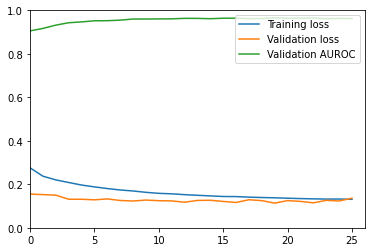

[0.9056897421184883, 0.9169505482813001]
[0.9056897421184883, 0.9169505482813001, 0.9320919836218391]
[0.9056897421184883, 0.9169505482813001, 0.9320919836218391, 0.9430812189970841]
[0.9056897421184883, 0.9169505482813001, 0.9320919836218391, 0.9430812189970841, 0.9469403419188075]
[0.9056897421184883, 0.9169505482813001, 0.9320919836218391, 0.9430812189970841, 0.9469403419188075, 0.9520346666199102]
[0.9056897421184883, 0.9169505482813001, 0.9320919836218391, 0.9430812189970841, 0.9469403419188075, 0.9520346666199102, 0.9524292374802787]
[0.9056897421184883, 0.9169505482813001, 0.9320919836218391, 0.9430812189970841, 0.9469403419188075, 0.9520346666199102, 0.9524292374802787, 0.9550654738400568]
[0.9056897421184883, 0.9169505482813001, 0.9320919836218391, 0.9430812189970841, 0.9469403419188075, 0.9520346666199102, 0.9524292374802787, 0.9550654738400568, 0.960140545825243]
[0.9056897421184883, 0.9169505482813001, 0.9320919836218391, 0.9430812189970841, 0.9469403419188075, 0.9520346666

In [ ]:
import time

# Best AUROC value during training
best_score = 0
model_path = "densenet.pth"
training_losses = []
validation_losses = []
validation_score = []


# Config progress bar
mb = master_bar(range(MAX_EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'Validation AUROC']
x = []

nonimproved_epoch = 0
start_time = time.time()

# Training each epoch
for epoch in mb:
    mb.main_bar .comment = f'Best AUROC score: {best_score}'
    x.append(epoch)

    # Training
    train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
    mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
    training_losses.append(train_loss)

    # Evaluating
    val_loss, new_score = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)
    val_loss = val_loss.to("cpu").numpy()
    mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_score))
    validation_losses.append(val_loss)
    validation_score.append(new_score)
    print(validation_score)

    # Update learning rate
    lr_scheduler.step(new_score)

    # Update training chart
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,epoch+1], [0,1])

    # Save model
    if best_score < new_score:
        mb.write(f"Improve AUROC from {best_score} to {new_score}")
        best_score = new_score
        nonimproved_epoch = 0
        torch.save({"model": model.state_dict(), 
                    "optimizer": optimizer.state_dict(), 
                    "best_score": best_score, 
                    "epoch": epoch, 
                    "lr_scheduler": lr_scheduler.state_dict()}, model_path)
    else: 
        nonimproved_epoch += 1
    if nonimproved_epoch > 10:
        break
        print("Early stopping")
    if time.time() - start_time > 3600*8:
        break
        print("Out of time")